In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
import json
import logging
import os

import torch

# from bytelatent.transformer import LMTransformer, LMTransformerArgs
from bytelatent.entropy_model_core import GPTConfig, GPT

logger = logging.getLogger()


def load_entropy_model(
        entropy_model_checkpoint_dir="/home/AD/sachith/CAPE-TST/timeblt2/bytelatent/data/pretrained_entropy_model/", 
        state_dict_path="/home/AD/sachith/CAPE-TST/timeblt2/bytelatent/data/pretrained_entropy_model/entropy_model.pt", 
        device="cpu"
        ):
    
    with open(os.path.join(entropy_model_checkpoint_dir, "params.json")) as fr:
        reloaded = json.loads(fr.read())

    torch.set_default_dtype(torch.bfloat16)
    model_params = reloaded["entropy_model"]
    logger.warning(
        "Update checkpoint to load attn and sliding window args from checkpoint"
    )

    entropy_model_args = GPTConfig(
        n_layer=model_params["n_layer"],
        n_head=model_params["n_head"],
        n_embd=model_params["n_embd"],
        dropout=model_params["dropout"],
        bias=model_params["bias"],
        vocab_size=model_params["vocab_size"],
        block_size=model_params["block_size"]
    )
    entropy_model = GPT(entropy_model_args)
    print(entropy_model)

    entropy_model.load_state_dict(torch.load(state_dict_path, map_location=device, weights_only=True)["model_state_dict"], strict=False)
    
    entropy_model.to(device)
    entropy_model = entropy_model.eval()
    # no grads for the model:
    for param in entropy_model.parameters():
        param.requires_grad = False
    return entropy_model, entropy_model_args

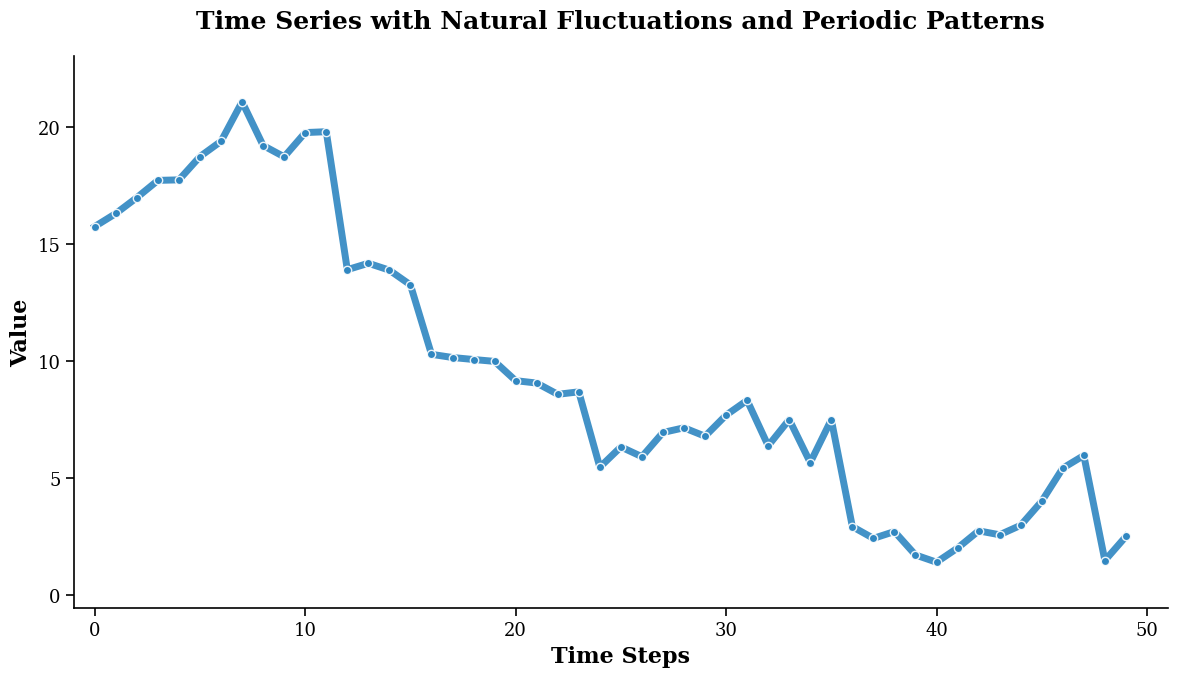

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate x values
x = np.arange(0, 50)

# Generate y values with reduced upward trend and periodic patterns
y = []
current_value = 15
base_trend = 0.1  # Reduced upward trend

for i in x:
    # Add periodic dips with some variation
    if i % 12 == 0 and i != 0:  # Dips every 12 points
        dip_size = np.random.uniform(3, 6)
        current_value -= dip_size
    elif i % 8 == 0 and i != 0:  # Smaller dips every 8 points
        small_dip = np.random.uniform(1, 2.5)
        current_value -= small_dip
    else:
        # Gentle upward trend with variation
        trend_component = base_trend + np.random.uniform(-0.2, 0.4)
        current_value += trend_component
    
    # Add some cyclical component
    cyclical = 1.5 * np.sin(i * 0.3) + 0.8 * np.cos(i * 0.15)
    current_value += cyclical * 0.3
    
    y.append(current_value)

# Add controlled noise
noise = np.random.normal(0, 0.5, len(y))
y = [val + n for val, n in zip(y, noise)]

# Create the figure with publication-quality styling
plt.figure(figsize=(12, 7))
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'axes.linewidth': 1.2,
    'lines.linewidth': 2.5
})

# Plot the main series
plt.plot(x, y, marker='o', markersize=6, linestyle='-', 
         color='B', linewidth=5, markerfacecolor='#2E86C1', 
         markeredgecolor='white', markeredgewidth=1, alpha=0.9)

# Customize the plot for paper quality
plt.xlabel('Time Steps', fontsize=16, fontweight='bold')
plt.ylabel('Value', fontsize=16, fontweight='bold')
plt.title('Time Series with Natural Fluctuations and Periodic Patterns', 
          fontsize=18, fontweight='bold', pad=20)

# Remove grid and customize axes
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.2)
plt.gca().spines['bottom'].set_linewidth(1.2)

# Set axis limits with some padding
plt.xlim(-1, 51)
y_min, y_max = min(y), max(y)
y_range = y_max - y_min
plt.ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)

# Customize tick parameters
plt.tick_params(axis='both', which='major', labelsize=13, 
                length=6, width=1.2, colors='black')

# Tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

# Optional: Save the figure in high quality for paper submission
# plt.savefig('time_series_figure.pdf', dpi=300, bbox_inches='tight', 
#             facecolor='white', edgecolor='none')